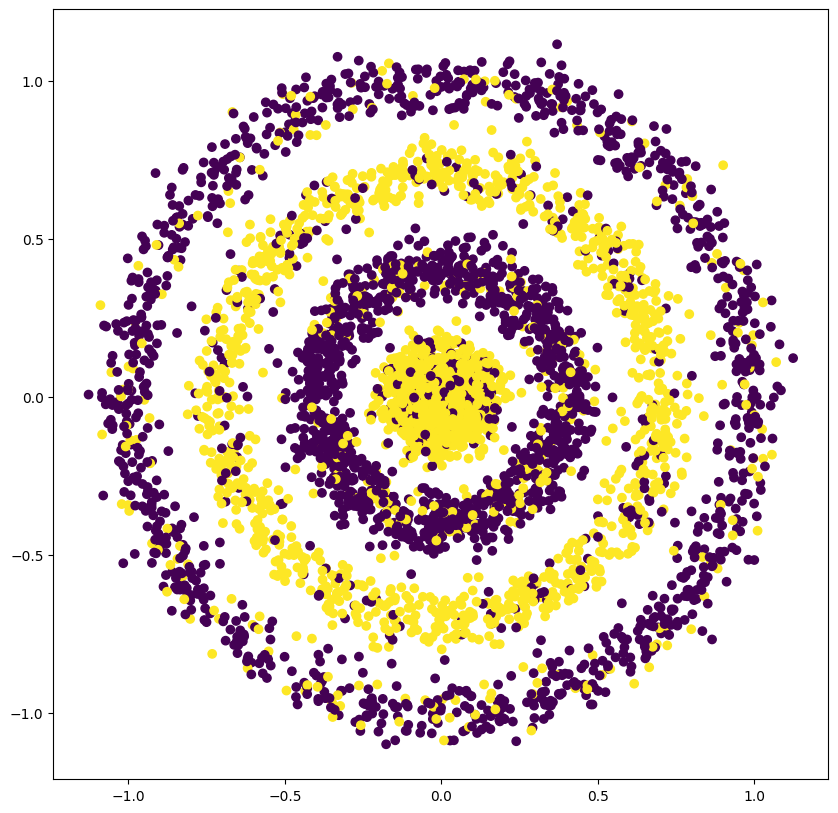

In [1]:
import os, sys, time, numpy, torch, matplotlib.pyplot

sys.path.append(os.path.abspath(os.path.join('../..')))  # Allow repository modules to be imported

from settings.concentric_spheres import get_dataloader
from utils.optimization import initialize

experiment = {
    'seed': 1,
    'dataset': 'cs',
    'input_dimension': 100, 
    'spheres_dimension': 2, 
    'number_of_spheres': 4, 
    'sample_size': 5000, 
    'batch_size': 5000, 
    'margin': 0.3, 
    'noise_std': .05,
    'epochs': 10000,
    'learning_rate': 0.01,
    'initial_hidden_units': 2,
    'bias': True,
    'convergence_epsilon': 0.00001,
    'target_accuracy': .85
}
override_saved_experiment = True

device, generator = initialize(experiment['seed'])
train_data, rotation_matrix = get_dataloader(**experiment, label_flipping=1. - experiment['target_accuracy'], generator=generator)
test_data = get_dataloader(**experiment, rotation_matrix=rotation_matrix, generator=generator)
inputs = []; labels = []
for batch_inputs, batch_labels in train_data: inputs.append(batch_inputs); labels.append(batch_labels)
inputs, labels = torch.concatenate(inputs), torch.concatenate(labels)

fig, ax = matplotlib.pyplot.subplots(figsize=(10, 10))
inputs_ = numpy.matmul(inputs.detach().cpu().numpy(), rotation_matrix.transpose())
ax.scatter(inputs_[:, 0], inputs_[:, 1], c=labels)

In [2]:
import ipycanvas

training_canvas, growth_metrics_canvas, input_domain_canvas = ipycanvas.Canvas(), ipycanvas.Canvas(), ipycanvas.Canvas()
training_canvas.width, training_canvas.height = 1200, 600
growth_metrics_canvas.width = 1200; growth_metrics_canvas.height = 400
input_domain_canvas.width = input_domain_canvas.height = 800
training_canvas.font = growth_metrics_canvas.font = input_domain_canvas.font = "30px arial"
args = ('Results will appear as processed', training_canvas.width / 4, training_canvas.height / 3)
training_canvas.fill_text(*args); growth_metrics_canvas.fill_text(*args); input_domain_canvas.fill_text(*args)

In [3]:
training_canvas

Canvas(height=600, width=1200)

In [4]:
growth_metrics_canvas

Canvas(height=400, width=1200)

In [5]:
input_domain_canvas

Canvas(height=800, width=800)

In [6]:
from utils.optimization import train, test, Accuracy, get_random_states, set_random_states
from utils.persistance import experiment_exists, load_experiment, save_experiment
from plots import plot_train_loss_and_accuracy, plot_growth_metrics, plot_samples_activation_hyperplanes
from growing_neural_network import GrowingNeuralNetwork

growing_epochs_interval = 200
device, generator = initialize(experiment['seed'])
if not override_saved_experiment and experiment_exists(**experiment):
    experiment = load_experiment(**experiment)
    model = GrowingNeuralNetwork.load(**experiment, classes=2, initial_depth=1).to(device)
    generator = set_random_states(experiment['random_states'])
    plot_train_loss_and_accuracy(**experiment, canvas=training_canvas)
    plot_growth_metrics(**experiment, canvas=growth_metrics_canvas)

else: 
    model = GrowingNeuralNetwork(**experiment).to(device)

train_data.generator = test_data.generator = generator
train_loss = torch.nn.CrossEntropyLoss() if model.classes > 2 else torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=experiment['learning_rate'])
if 'train' not in experiment:
    experiment.update({
        'train': [test(train_data, model, train_loss, device)],
        'train_time': [0],
        'test': [test(test_data, model, train_loss, device, verbose=False)],
        'train_accuracy': [test(train_data, model, Accuracy, device, verbose=False)],
        'test_accuracy': [test(test_data, model, Accuracy, device, verbose=False)],
        'architecture': model.architecture,
        'growth_metrics': []
    })

epochs_already_executed = len(experiment['train'])
for epoch in range(epochs_already_executed, experiment['epochs'] + 1):
    start_time = time.time()
    train(train_data, model, train_loss, optimizer, device, verbose=False)
    end_time = time.time()
    train_time = experiment['train_time'][-1] + end_time - start_time
    train_loss_value = test(train_data, model, train_loss, device, 
                            calculate_gradients=True, retain_graph=True, verbose=False)
    model.calculate_growth_metrics()
    if ((epoch % growing_epochs_interval == 0 or epoch == experiment['epochs']) and 
        abs(experiment['train'][-1] - experiment['train'][-2]) < experiment['convergence_epsilon']):
        print(f'Convergence achieve according to convergence_epsilon = {experiment["convergence_epsilon"]}')
        if model.remove_dead_units() or model.grow():
            optimizer.zero_grad()
            optimizer = torch.optim.SGD(model.parameters(), lr=experiment['learning_rate'])
            experiment['architecture'] = model.architecture

    test_loss_value = test(test_data, model, train_loss, device, verbose=False)
    train_accuracy = test(train_data, model, Accuracy, device, verbose=False)
    test_accuracy = test(test_data, model, Accuracy, device, verbose=False)
    experiment['train'].append(train_loss_value)
    experiment['train_time'].append(train_time)
    experiment['test'].append(test_loss_value)
    experiment['train_accuracy'].append(train_accuracy)
    experiment['test_accuracy'].append(test_accuracy)
    experiment['growth_metrics'] += [{**growth_metrics, 'epoch': epoch} for growth_metrics in model.growth_metrics]
    if epoch % growing_epochs_interval == 0 or epoch == experiment['epochs']:
        model.save()
        experiment['random_states'] = get_random_states()
        save_experiment(experiment)
        plot_train_loss_and_accuracy(**experiment, canvas=training_canvas)
        plot_growth_metrics(**experiment, canvas=growth_metrics_canvas)
        plot_samples_activation_hyperplanes(
            dataloader=train_data, model=model, rotation_matrix=rotation_matrix, 
            canvas=input_domain_canvas, **experiment
        )


Convergence achieve according to convergence_epsilon = 1e-05
Width growth: Two unit with opposing signs were added to layer 0 which now has 4 units
Convergence achieve according to convergence_epsilon = 1e-05
Width growth: Two unit with opposing signs were added to layer 0 which now has 6 units
Convergence achieve according to convergence_epsilon = 1e-05
Width growth: Two unit with opposing signs were added to layer 0 which now has 8 units
Convergence achieve according to convergence_epsilon = 1e-05
Width growth: Two unit with opposing signs were added to layer 0 which now has 10 units
Convergence achieve according to convergence_epsilon = 1e-05
Width growth: Two unit with opposing signs were added to layer 0 which now has 12 units
Convergence achieve according to convergence_epsilon = 1e-05
Width growth: Two unit with opposing signs were added to layer 0 which now has 14 units
Convergence achieve according to convergence_epsilon = 1e-05
Width growth: Two unit with opposing signs were 

KeyboardInterrupt: 